In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download adacslicml/breast-histopathology-images

 99% 158M/159M [00:01<00:00, 106MB/s]
100% 159M/159M [00:01<00:00, 114MB/s]


In [ ]:
! unzip breast-histopathology-images

Streaming output truncated to the last 5000 lines.
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1701_y1351_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1751_y1451_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1751_y1851_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1751_y2101_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1751_y501_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1801_y1801_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1801_y1901_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1851_y2001_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1851_y2051_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1851_y601_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1851_y851_class1.png  
  inflating: BreastCancer/train/1_Cancer/9077_idx5_x1901_y1001_class1.png  
  inflating: BreastCancer/train/1_Cancer

In [ ]:
ls

BreastCancer/  breast-histopathology-images.zip  kaggle.json  sample_data/


In [ ]:
ls BreastCancer

test/  train/  valid/


In [ ]:
#ls BreastCancer/train/1_Cancer/

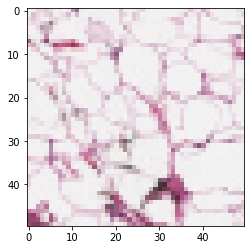

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('BreastCancer/train/0_NoCancer/9383_idx5_x951_y1901_class0.png')
imgplot = plt.imshow(img)
plt.show()

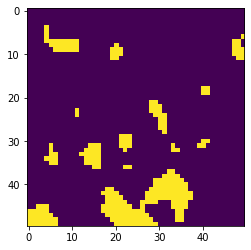

In [ ]:
import cv2
img = cv2.imread('BreastCancer/train/0_NoCancer/9383_idx5_x951_y1901_class0.png',0)
img = cv2.GaussianBlur(img, (5, 5), 0)
ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imgplot = plt.imshow(img)
plt.show()

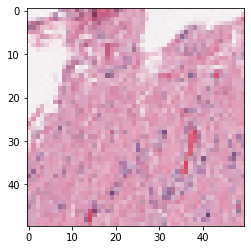

In [ ]:
img = mpimg.imread('BreastCancer/train/1_Cancer/13691_idx5_x2351_y1151_class1.png')
imgplot = plt.imshow(img)
plt.show()

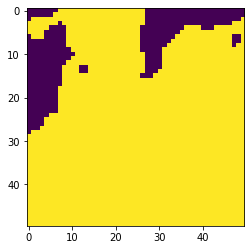

In [ ]:
img = cv2.imread('BreastCancer/train/1_Cancer/13691_idx5_x2351_y1151_class1.png',0)
img = cv2.GaussianBlur(img, (5, 5), 0)
ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow

# Return a dictionary that holds all images category by category. 
def load_images_from_folder(folder):
    images = {}
    ct = 0
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path)[:5515]:
          ct += 1
          img = cv2.imread(path + "/" + cat,0)
          img = cv2.GaussianBlur(img, (5, 5), 0)
          ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
          if img is not None:
            category.append(img)
          images[filename] = category
    #cv2_imshow(img)
    #print('image ->' + cat)
    print(ct)
    return images

images = load_images_from_folder('BreastCancer/train')  # take all train images category by category 
test = load_images_from_folder("BreastCancer/test") # take test images 

11030
4162


In [ ]:
#images['0_NoCancer'][0]

In [ ]:
type(images['0_NoCancer'][0])

numpy.ndarray

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 34.3 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 30.6 MB 1.4 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            #print(img)
            kp, des = sift.detectAndCompute(img, None)
            try:
              descriptor_list.extend(des)
            except:
              continue
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(images) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1]

In [ ]:
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words    
visual_words = kmeans(19, descriptor_list) 

In [ ]:
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words) 

In [ ]:
#type(bovw_train)
#type(bovw_train['0_NoCancer'])
#bovw_train['0_NoCancer'][0]

In [ ]:
import pickle
dictionary_data = {"kmeans_19": visual_words, "train":bovw_train, "test":bovw_test}

a_file = open("data_19.pkl", "wb")
pickle.dump(dictionary_data, a_file)
a_file.close()

In [ ]:
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Call the knn function    
results_bowl = knn(bovw_train, bovw_test)

In [ ]:
import pickle
pickle.dump(results_bowl, open("model.pkl", "wb"))

In [ ]:
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: " + str(avg_accuracy) + " %")
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : " + str(acc) + " %")
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl) 

Average accuracy: 63.459166049839624 %

Class based accuracies: 

0_NoCancer : 69.1375129892622 %
1_Cancer : 49.39965694682676 %


In [ ]:
results_bowl

[4053, 2572, {'0_NoCancer': [1996, 2887], '1_Cancer': [576, 1166]}]

In [ ]:
test2 = 2887*['0NoCancer']
predi3 = 2008*['0NoCancer']
predi4 = 879*['1Cancer']
test = 1166*['1Cancer']
predi = 556*['1Cancer']
predi2 = 610*['0NoCancer']
test.extend(test2)
predi.extend(predi2)
predi.extend(predi3)
predi.extend(predi4)
#test
type(predi)
len(predi)

4053

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test, predi)
print(cm)

[[2008  879]
 [ 610  556]]


In [ ]:
print(classification_report(test, predi))

              precision    recall  f1-score   support

   0NoCancer       0.77      0.70      0.73      2887
     1Cancer       0.39      0.48      0.43      1166

    accuracy                           0.63      4053
   macro avg       0.58      0.59      0.58      4053
weighted avg       0.66      0.63      0.64      4053



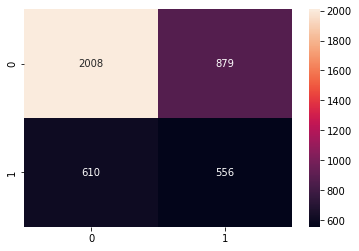

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True,fmt='d')